# Variational quantum kernel density estimation with 2 Dimensional data sets

Diego Useche

Data taken from https://zenodo.org/records/7822851



## Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
!pip install tensorcircuit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.0/342.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 7.0 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/diegour1/qmc.git

  Cloning https://github.com/diegour1/qmc.git to /tmp/pip-req-build-ipa3qm4y
  Running command git clone --filter=blob:none --quiet https://github.com/diegour1/qmc.git /tmp/pip-req-build-ipa3qm4y
  Resolved https://github.com/diegour1/qmc.git to commit 4c2db4b21508f28466743eaf0b13fe70814f65dc
  Preparing metadata (setup.py) ... done
  Created wheel for qmc: filename=qmc-0.0.1-py3-none-any.whl size=12988 sha256=937272c6af26699aa07cc8a24b3ab3cb874ca731fbf77e75323e88db488f712d
  Stored in directory: /tmp/pip-ephem-wheel-cache-mi5w6i3n/wheels/9f/94/66/55600fd5fe039b621ab7ee795c96f41946d90a9efaf4914d6e
Successfully built qmc


In [ ]:
#!nvidia-smi

# 2 Dimensions

In [ ]:
def calculate_constant_qmkde(gamma=1, dimension = 1):
  sigma = (4*gamma)**(-1/2)
  coefficient = 1 /  (2*np.pi*sigma**2)**(dimension/2)
  return coefficient

In [ ]:
def calculate_constant_log_qmkde(gamma=1, dimension = 1):
  sigma = (4*gamma)**(-1/2)
  coefficient = np.log(1) - (dimension/2.) *   np.log(2*np.pi*sigma**2)
  return coefficient

In [ ]:
def raw_kde(x_test, x_train, gamma=1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  constant_outside = 1/(np.size(x_train) * (2*np.pi*sigma**2)**(x_train.shape[1]/2))
  return constant_outside * np.sum(exponential)

In [ ]:
def raw_log_kde(x_test, x_train, gamma=1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  constant_outside = np.log(1) - np.log(np.size(x_train)) - (x_train.shape[1]/2) * np.log(2*np.pi*sigma**2)
  return constant_outside + np.log(np.sum(exponential))

In [ ]:
import matplotlib.pyplot as plt

def plot(X_train, X_train_density, X_test, X_test_density, name = "dataset"):
    plt.axes(frameon = 0)
    plt.grid()
    plt.scatter(X_test[:,0],  X_test[:,1], c = X_test_density , alpha = .5, s = 3, linewidths= 0.0000001)
    plt.colorbar()
    plt.title('arc dataset')
    plt.savefig(f'{name}.png',dpi = 300)
    plt.show()

# 2 Dim Datasets

## Binomial dataset

In [ ]:
tfd = tfp.distributions

# Initialize a single 2-variate Gaussian.
mvn = tfd.MultivariateNormalDiag(
    loc=[1., -1],
    scale_diag=[1, 2.])

X = mvn.sample(sample_shape=10000, seed = 1)


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
A = euclidean_distances(X, X)
A[np.triu_indices_from(A, k=1)]

array([7.9033756, 2.0053935, 7.3504186, ..., 1.0203874, 2.5100377,
       1.5725329], dtype=float32)

In [ ]:
batch_size = 32

from  sklearn import model_selection
X_train, val_data = model_selection.train_test_split(X.numpy(), test_size=0.3)

train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
batched_train_data = train_dataset.batch(batch_size)

In [ ]:
x, y = np.mgrid[-6:6:.1, -6:6:.1]
pos = np.dstack((x, y))
X_plot = pos.reshape([14400,2])

real_prob = mvn.prob(X_plot)

log max probability: tf.Tensor(
[8.00581593e-14 9.06043361e-14 1.02283904e-13 ... 1.77889403e-09
 1.50266632e-09 1.26616140e-09], shape=(14400,), dtype=float32)
log min probability: tf.Tensor(
[8.00581593e-14 9.06043361e-14 1.02283904e-13 ... 1.77889403e-09
 1.50266632e-09 1.26616140e-09], shape=(14400,), dtype=float32)


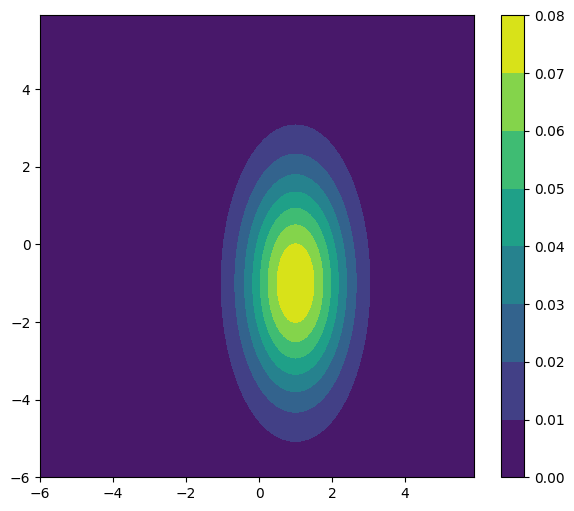

In [ ]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

print("log max probability:", real_prob)
print("log min probability:", real_prob)

#fig2 = plt.figure()
#ax2 = fig2.add_subplot(111)
plt.contourf(x, y, real_prob.numpy().reshape([120,120]))
plt.colorbar()
plt.savefig("spiralsdmkde.pdf")

## Potential 1 dataset

In [ ]:
def load_potential_1(train_size, test_size, dimension=2):

    print(f"loading potential_1 trian_size: {train_size} test_size: {test_size} dimension: {dimension}")

    X = np.loadtxt("NF1_1M.csv").astype(np.float32)
    X_densities = np.loadtxt("NF1_1M_densities.csv").astype(np.float32)

    X_train = X[:train_size, :]
    X_train_densities = X_densities[:train_size]
    X_test = X[train_size: train_size + test_size, :]
    X_test_densities = X_densities[train_size: train_size + test_size]

    return X_train, X_train_densities, X_test, X_test_densities



In [ ]:
!gdown --id 1iGX6Ux9agD7Naom0HFAu2sxxaQAKVFVX
!gdown --id 1kW7UPgICZCkjIAWZ-oWDwLCtYl0LMNar

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1iGX6Ux9agD7Naom0HFAu2sxxaQAKVFVX
To: /content/NF1_1M_densities.csv
100% 25.0M/25.0M [00:00<00:00, 64.6MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kW7UPgICZCkjIAWZ-oWDwLCtYl0LMNar
To: /content/NF1_1M.csv
 14% 7.34M/51.0M [00:00<00:01, 22.3MB/s]Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
  File "/usr/local/lib/python3.10/dist-packages/gdown/cli.py", line 169, in main
    download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 328

In [ ]:
X_train, X_train_densities, X_test, X_test_densities = load_potential_1(80000,1000,dimension=2)

loading potential_1 trian_size: 80000 test_size: 1000 dimension: 2


FileNotFoundError: NF1_1M.csv not found.

In [ ]:
plot(X_train, X_train_densities, X_test, X_test_densities)

In [ ]:
x, y = np.mgrid[-4:4:(8/120), -4:4:(8/120)]
pos = np.dstack((x, y))
X_plot = pos.reshape([14400,2])

## Potential 2 dataset

In [ ]:
!gdown --id 1VSXlzTLtrS5E7QmWwhyRHuSSKE1HvbZX
!gdown --id 18nAP1faHJjpzKskyhenvStI1jM83SIzO

In [ ]:
def load_potential_2(train_size, test_size, dimension=2):

    print(f"loading potential_2 trian_size: {train_size} test_size: {test_size} dimension: {dimension}")

    X = np.load("nf2.npy").astype(np.float32)
    X_densities = np.loadtxt("NF2_densities.csv").astype(np.float32)

    X_train = X[:train_size, :]
    X_train_densities = X_densities[:train_size]
    X_test = X[train_size: train_size + test_size, :]
    X_test_densities = X_densities[train_size: train_size + test_size]

    return X_train, X_train_densities, X_test, X_test_densities

In [ ]:
X_train, X_train_densities, X_test, X_test_densities = load_potential_2(80000,1000,dimension=2)

In [ ]:
plot(X_train, X_train_densities, X_test, X_test_densities)

In [ ]:
x, y = np.mgrid[-4:4:(8/120), -3:3:(6/120)]
pos = np.dstack((x, y))
X_plot = pos.reshape([14400,2])

## ARC dataset

Weird Gaussians from `Masked Autoregressive Flow for Density Estimation`
***

See the article [here](https://arxiv.org/pdf/1705.07057.pdf) where the distribution of the data is given by the following density:

$$
p(x,y) = \mathcal{N}\left(x_2| 0,4\right) \mathcal{N}\left(x_1|\frac{1}{4}x_2^2,1\right)
$$

### Dataset Generation

In [ ]:
dataset_size = 40_000

In [ ]:
x2_dist = tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(dataset_size)
x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                scale=tf.ones(dataset_size, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

In [ ]:
X_densities = x2_dist.prob(x_samples[:,1]) * x1.prob(x_samples[:,0])

True densities

In [ ]:
x2 = tfp.distributions.Normal(loc = 0., scale = 4.)
x1 = tfp.distributions.Normal(loc = .25 * tf.square(x_samples[:,1]), scale = tf.ones(40_000, dtype=tf.float32))

In [ ]:
X_densities = x2.prob(x_samples[:,1]) * x1.prob(x_samples[:,0])

Scatter plot of the data

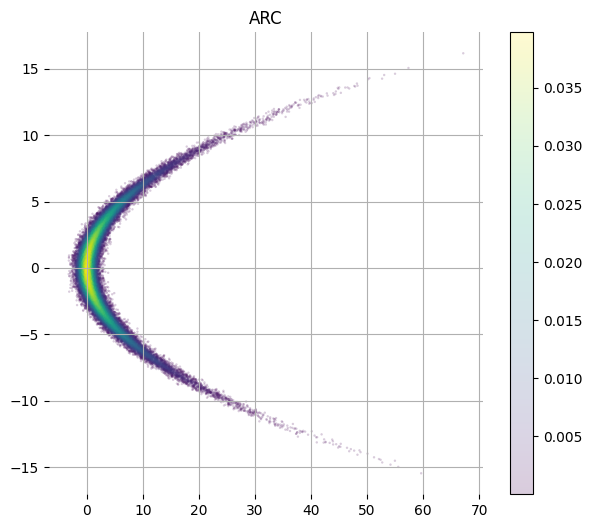

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(x_samples[:,0],  x_samples[:,1], c = X_densities.numpy() , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('ARC')
plt.savefig('alldensities_arc.png',dpi = 300)
plt.show()

To generate mesh grid data that will be used to calculate probability density plot

In [ ]:
import scipy.stats

In [ ]:
x, y = np.mgrid[-10:40:(50/120), -15:15:(30/120)]
pos = np.dstack((x, y))
X_plot = pos.reshape([14400,2])

real_prob = x2_dist.prob(X_plot[:,1]) * scipy.stats.norm(0.25 * np.square(X_plot[:,1]), 1).pdf(X_plot[:,0])

In [ ]:
plt.rcParams["figure.figsize"] = (20*0.25,15*0.25)

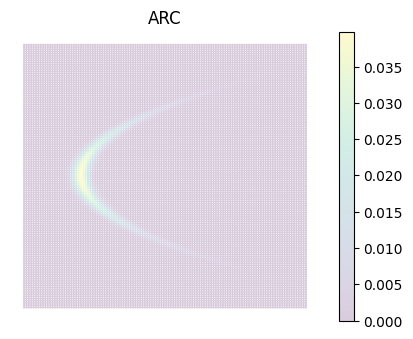

In [ ]:
plt.axes(frameon = 0)
plt.grid()
#plt.scatter(x, y, c = real_prob.numpy().reshape([500,300]) , alpha = .2, s = 3, linewidths= 0.0000001)
plt.scatter(x, y, c = real_prob.numpy().reshape([120,120]) , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('ARC')
plt.yticks([])
plt.xticks([])
plt.savefig('alldensities_arc.png',dpi = 300)
plt.show()

In [ ]:
x_samples.shape

TensorShape([40000, 2])

In [ ]:
from  sklearn import model_selection
batch_size = 32
X_train, test_set = model_selection.train_test_split(x_samples.numpy(), test_size=0.3)

train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
batched_train_data = train_dataset.batch(batch_size)

## Star eight dataset

In [ ]:
!gdown --id 1yr0NkgYXdiGi2UsDCgjfcRcfHax7wmCz
!gdown --id 103NFYP5uvpht9TUeEF3ObqJa_8HT3xME
!gdown --id 1F879MIVT2EaS33AWM3kPJ3gQwtVcvkap
!gdown --id 1ppUWUUPRxkl4alDqcDllzS2KckMN9g_0

In [ ]:
def load_star_eight(train_size, test_size, dimension=2):
    print(f"loading star_eight trian_size: {train_size} test_size: {test_size} dimension: {dimension}")

    X_train = np.load("star_eight_train.npy").astype(np.float32)[:train_size, :dimension]
    X_train_densities = np.load("star_eight_train_density.npy").astype(np.float32) [:train_size]
    X_test = np.load("star_eight_test.npy").astype(np.float32)[:test_size, :dimension]
    X_test_densities = np.load("star_eight_test_density.npy").astype(np.float32)[:test_size]
    return X_train, X_train_densities, X_test, X_test_densities

In [ ]:
X_train, X_train_densities, X_test, X_test_densities = load_star_eight(80000,1000,dimension=2)

X_train.shape

In [ ]:
plot(X_train, X_train_densities, X_test, X_test_densities)

In [ ]:
x, y = np.mgrid[-7:7:(14/120), -7:7:(14/120)]
pos = np.dstack((x, y))
X_plot = pos.reshape([14400,2])

# Constants




In [ ]:
GAMMA_DICT = {"Binomial": 2., "Potential 1": 4., "Potential 2": 16., "Arc": 4., "Star": 16.}
GAMMA = GAMMA_DICT["Arc"] ## change GAMMA accordingly
DIM_X = X_train.shape[1]
EPOCHS = 15 ## set 15 for the final experiments
N_RFFS = 32 ## set 64 for the final experiments
RANDOM_STATE = 15
PS_SIZE = 128 ## set 256 for the final experiments

# 2.5 RAW-KDE

In [ ]:
def calculate_constant_qmkde(gamma=1, dimension = 1):
  sigma = (4*gamma)**(-1/2)
  coefficient = 1 /  (2*np.pi*sigma**2)**(dimension/2)
  return coefficient

In [ ]:
def raw_kde(x_test, x_train, gamma=1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  constant_outside = 1/(np.size(x_train) * (2*np.pi*sigma**2)**(x_train.shape[1]/2))
  return constant_outside * np.sum(exponential)

In [ ]:
def raw_kde(x_test, x_train, gamma=1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  constant_outside = 1/(np.size(x_train) * (2*np.pi*sigma**2)**(x_train.shape[1]/2))
  return constant_outside * np.sum(exponential)

In [ ]:
# Given the eigenvalues this function return a Unitary gate which converts the |0> -> |psi_train>
def create_U_train(x_train_param, seed=0):
  np.random.seed(seed)
  size_U = len(x_train_param)
  U_train = np.zeros((size_U, size_U), dtype = np.complex128)
  x_1 = x_train_param
  U_train[:, 0] = x_1
  for i in range(1, size_U):
    x_i =  np.complex128(np.random.randn(size_U) + 1j*np.random.randn(size_U))
    for j in range(0, i):
      x_i -= x_i.dot(np.conjugate(U_train[:, j])) * U_train[:, j]
    x_i = x_i/np.linalg.norm(x_i)
    U_train[:, i] = x_i

  return U_train

In [ ]:
raw_kde_probability = np.array([raw_kde(x_temp[np.newaxis,:], X_train, GAMMA) for x_temp in X_plot])
raw_kde_probability_train = np.array([raw_kde(x_temp[np.newaxis,:], X_train, GAMMA) for x_temp in X_train])

GAMMA, raw_kde_probability.shape, raw_kde_probability_train.shape

(4.0, (14400,), (28000,))

max probability: 0.01910650996598554
min probability: 0.0
log max probability: -3.9577261660854455
log min probability: -inf


<ipython-input-36-7f9340654f3f>:15: RuntimeWarning: divide by zero encountered in log
  print("log min probability:", np.log(raw_kde_probability.min()))


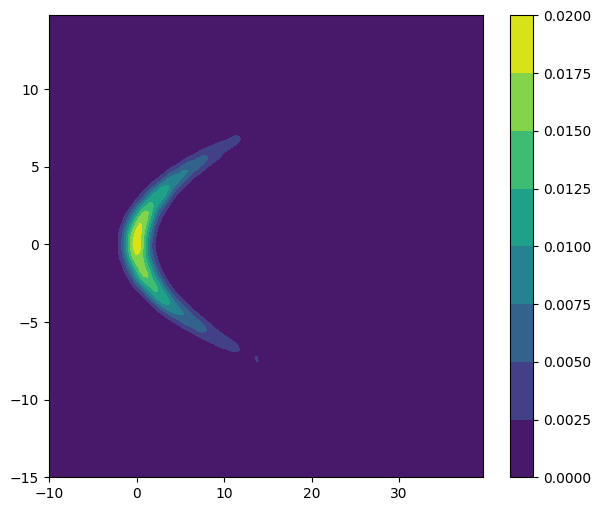

In [ ]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

print("max probability:", raw_kde_probability.max())
print("min probability:",raw_kde_probability.min())

print("log max probability:", np.log(raw_kde_probability.max()))
print("log min probability:", np.log(raw_kde_probability.min()))

plt.contourf(x, y, raw_kde_probability.reshape([120,120]))
plt.colorbar()
plt.savefig("spiralsdmkde.pdf")

# DMKDE Classical

In [ ]:
import qmc.tf.layers as qmc_layers
import qmc.tf.models as qmc_models

In [ ]:
type_ffs = "qrff"
if type_ffs == "rff":
  fm_x = qmc_layers.QFeatureMapRFF(DIM_X, dim=N_RFFS, gamma=GAMMA/2, random_state= RANDOM_STATE)
  qmd = qmc_models.QMDensity(fm_x, N_RFFS)
elif type_ffs == "qrff":
  fm_x = qmc_layers.QFeatureMapComplexRFF(DIM_X, dim=N_RFFS, gamma=GAMMA/2, random_state= RANDOM_STATE)
  qmd = qmc_models.ComplexQMDensity(fm_x, N_RFFS)
qmd.compile()
qmd.fit(X_train, epochs=1)
predictions_classical = tf.cast(qmd.predict(X_plot), tf.float32).numpy()
predictions_classical_train = tf.cast(qmd.predict(X_train), tf.float32).numpy()

450/450 [==============================] - 1s 2ms/step


875/875 [==============================] - 1s 2ms/step


max probability: 0.05737777
min probability: 0.023106221
log max probability: -2.8580983
log min probability: -3.7676535


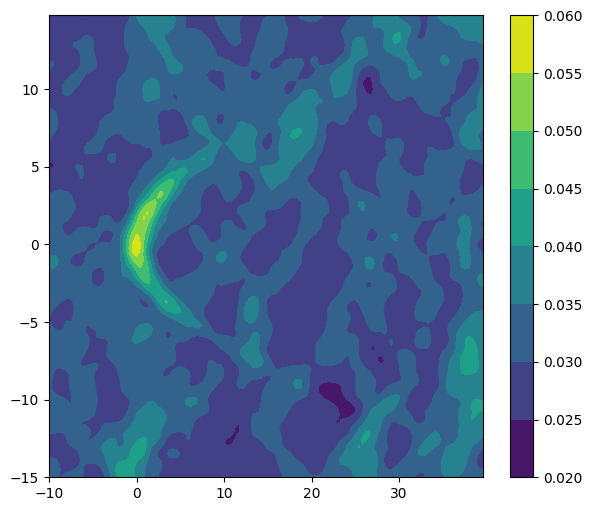

In [ ]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

print("max probability:", predictions_classical.max())
print("min probability:", predictions_classical.min())

print("log max probability:", np.log(predictions_classical.max()))
print("log min probability:", np.log(predictions_classical.min()))

plt.contourf(x, y, predictions_classical.reshape([120,120]))
plt.colorbar()
plt.savefig("spiralsdmkde.pdf")

# VQ-KDE Mixed with QRFF


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
### DMKDE mixed

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr



tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)


class VQKDE_QRFF:
    r"""
    Defines the ready-to-use Density Matrix Kernel Density Estimation (DMKDE) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """

    def __init__(self, dim_x_param, auto_compile=True, var_pure_state_size=64, gamma=2., epochs=15):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.var_pure_state_parameters_size = 2*var_pure_state_size - 2
        self.epochs = epochs

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_pure_state_parameters_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()


    def layer(
            self,
            U_dagger,
            var_pure_state_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probability of :math:`|000\rangle` state for density estimation.
        """

        n_rffs_temp = U_dagger.shape[1]
        n_total_qubits_temp = int(np.log2((len(var_pure_state_param)+2)/2))
        n_qrff_qubits_temp = int(np.log2(n_rffs_temp))

        index_it = iter(np.arange(len(var_pure_state_param)))

        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(n_total_qubits_temp)

        def circuit_base_ry_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.ry(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        def circuit_base_rz_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.rz(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        # Learning pure state
        for i in range(1, n_total_qubits_temp+1):
            circuit_base_ry_n(self.circuit, i, i-1)

        # Learning pure state complex phase
        for j in range(1, n_total_qubits_temp+1):
            circuit_base_rz_n(self.circuit, j, j-1)

        # Value to predict
        self.circuit.any(
            *[n for n in range(n_qrff_qubits_temp)], unitary=U_dagger
        )

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        return (1./(self.epochs))*\
                tc.backend.real(
                    tf.cast(self.gamma/pi, tf.complex128)*\
                    tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qrff_qubits_temp, n_total_qubits_temp)]
                    )[0, 0]
                )

    def loss(self, x_pred, y_pred):
        return -tf.reduce_sum(tf.math.log(y_pred))

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam(0.0005),
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.loss,
            optimizer=optimizer,
            metrics=[tf.keras.metrics.KLDivergence()],
            **kwargs
        )

    def fit(self, x_train, y_train, batch_size=16, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size=batch_size, epochs=self.epochs, **kwargs)

    def predict(self, x_test):
        r"""
        Method to make predictions with the trained model.

        Args:
            x_test:

        Returns:
            The predictions of the PDF of the input data.
        """

        return (tf.math.pow((self.gamma/(pi)), self.dim_x/2)*\
                self.model.predict(x_test)).numpy()

## VQ-KDE mixed with QRFF training

In [ ]:
weights_ffs_temp = fm_x.rff_weights.numpy()/2. ## weights extracted from classical DMKDE

weights_ffs_temp.mean(), weights_ffs_temp.std()

(-0.06322023, 0.9963657)

In [ ]:
def predict_features(X_param, var_param, gamma_param):
  X_feat = np.ones((len(X_param), var_param.shape[1]), dtype = np.complex128)
  X_feat[:, :] = np.cos(np.sqrt(gamma_param)*(X_param @ var_param)) - 1j*np.sin(np.sqrt(gamma_param)*(X_param @ var_param))
  X_feat *= np.sqrt(1/(var_param.shape[1]))
  return X_feat

X_feat_train = predict_features(X_train, weights_ffs_temp, GAMMA)
X_feat_test = predict_features(X_plot, weights_ffs_temp, GAMMA)
y_expected =  raw_kde_probability_train

X_feat_train.shape, X_feat_test.shape, y_expected.shape

((28000, 32), (14400, 32), (28000,))

In [ ]:
## Convert states to unitaries

U_train_conjTrans = np.array([np.conjugate(create_U_train(X_feat_train[i]).T) for i in range(len(X_feat_train))])
U_test_conjTrans = np.array([np.conjugate(create_U_train(X_feat_test[i]).T) for i in range(len(X_feat_test))])

U_train_conjTrans.shape, U_test_conjTrans.shape

((28000, 32, 32), (14400, 32, 32))

In [ ]:
vc = VQKDE_QRFF(dim_x_param = DIM_X, var_pure_state_size=PS_SIZE, gamma=GAMMA, epochs = EPOCHS)

vc.fit(U_train_conjTrans, y_expected, batch_size=16)

Epoch 1/15
1750/1750 [==============================] - 206s 30ms/step - loss: 94.5820 - kullback_leibler_divergence: 0.1988
Epoch 2/15
1750/1750 [==============================] - 46s 26ms/step - loss: 93.1349 - kullback_leibler_divergence: 0.1856
Epoch 3/15
1750/1750 [==============================] - 52s 30ms/step - loss: 90.1712 - kullback_leibler_divergence: 0.1522
Epoch 4/15
1750/1750 [==============================] - 49s 28ms/step - loss: 85.7416 - kullback_leibler_divergence: 0.0958
Epoch 5/15
1750/1750 [==============================] - 48s 28ms/step - loss: 84.3565 - kullback_leibler_divergence: 0.0814
Epoch 6/15
1750/1750 [==============================] - 52s 30ms/step - loss: 84.2029 - kullback_leibler_divergence: 0.0805
Epoch 7/15
1750/1750 [==============================] - 46s 26ms/step - loss: 84.1632 - kullback_leibler_divergence: 0.0803
Epoch 8/15
1750/1750 [==============================] - 44s 25ms/step - loss: 84.0779 - kullback_leibler_divergence: 0.0795
Epoch 9

In [ ]:
predictions_quantum_dmkde_mixed = vc.predict(U_test_conjTrans)
predictions_quantum_dmkde_mixed

450/450 [==============================] - 106s 15ms/step


array([0.00230336, 0.0021587 , 0.00186695, ..., 0.00513   , 0.00458196,
       0.0039065 ], dtype=float32)

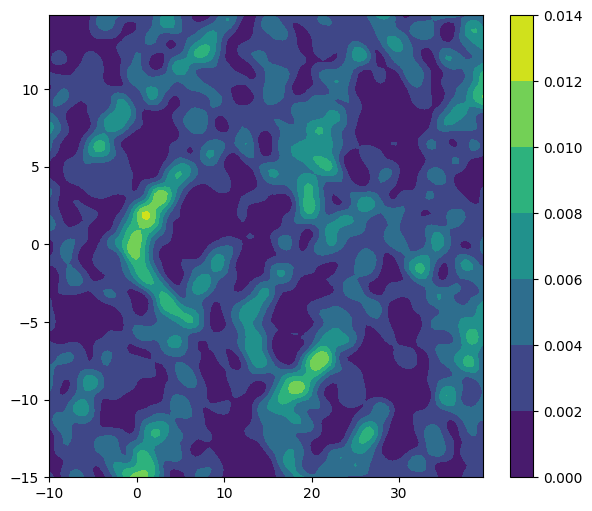

In [ ]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

plt.contourf(x, y, predictions_quantum_dmkde_mixed.reshape([120,120]))
plt.colorbar()
plt.savefig("spiralsdmkde.pdf")

In [ ]:
def evaluate_model(y_true_param, y_pred_param):

  # Kl divergence
  #kl_divergence_temp = tf.keras.metrics.kl_divergence(y_true_param, y_pred_param).numpy()
  kl_divergence_temp = entropy(y_true_param, y_pred_param)

  # Calculate the ranks of the density values
  ranks1 = y_true_param.argsort().argsort()
  ranks2 = y_pred_param.argsort().argsort()

  # Calculate the Spearman correlation
  spearman_corr_temp, _ = spearmanr(ranks1, ranks2)

  # Calculate the absolute differences at each evaluation point
  absolute_differences_temp = np.abs(y_true_param - y_pred_param)

  # Average the absolute differences
  average_error_temp = np.mean(absolute_differences_temp)

  print("KL Divergence:", kl_divergence_temp)
  print("Spearman Correlation:", spearman_corr_temp)
  print("Mean Average Error:", average_error_temp)

In [ ]:
print("                                          ")
print("------ KDE vs DMKDE mixed average --------")
print("                                          ")
evaluate_model(raw_kde_probability, predictions_classical)
print("                                          ")
print("------ KDE vs VQ-KDE QRFF ------------")
print("                                          ")
evaluate_model(raw_kde_probability, predictions_quantum_dmkde_mixed)
print("                                          ")
print("--DMKDE mixed average vs VQ-KDE QRFF--")
print("                                          ")
evaluate_model(predictions_classical, predictions_quantum_dmkde_mixed)

                                          
------ KDE vs DMKDE mixed average --------
                                          
KL Divergence: 2.614001995560538
Spearman Correlation: 0.20029738637456945
Mean Average Error: 0.0310361285263212
                                          
------ KDE vs VQ-KDE QRFF ------------
                                          
KL Divergence: 2.2348853477722863
Spearman Correlation: 0.04491297551719864
Mean Average Error: 0.0031128889270579593
                                          
--DMKDE mixed average vs VQ-KDE QRFF--
                                          
KL Divergence: 0.17133142
Spearman Correlation: 0.5300156667230052
Mean Average Error: 0.0280397


# VQ-KDC Mixed with QEFF

This method uses QEFF, and normalizes the training with the number of epochs.

In [ ]:
### Variational DMKDE with QEFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr



tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)


class VQKDE_QEFF:
    r"""
    Defines the ready-to-use Density Matrix Kernel Density Estimation (DMKDE) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """

    def __init__(self, num_ffs_param, dim_x_param, auto_compile=True, var_pure_state_size=64, gamma=2., epochs=15):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.n_rffs = num_ffs_param
        self.var_pure_state_parameters_size = 2*var_pure_state_size - 2
        self.qeff_weights =  tf.random.normal((dim_x_param, int(num_ffs_param*2-2)), mean=0.0, stddev=1.0/np.sqrt(num_ffs_param-1), dtype=tf.dtypes.float64)
        self.epochs = epochs

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_pure_state_parameters_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()


    def layer(
            self,
            x_sample_param,
            var_pure_state_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probability of :math:`|000\rangle` state for density estimation.
        """

        n_total_qubits_temp = int(np.log2((len(var_pure_state_param)+2)/2))
        n_qeff_qubits_temp = int(np.log2(self.n_rffs))

        ### indices pure state
        index_it = iter(np.arange(len(var_pure_state_param)))

        ### indices qeff
        index_iter_qeff = iter(np.arange(self.qeff_weights.shape[1]))

        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(n_total_qubits_temp)

        def circuit_base_ry_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.ry(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        def circuit_base_rz_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.rz(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        # Learning pure state
        for i in range(1, n_total_qubits_temp+1):
            circuit_base_ry_n(self.circuit, i, i-1)

        # Learning pure state complex phase
        for j in range(1, n_total_qubits_temp+1):
            circuit_base_rz_n(self.circuit, j, j-1)

        # Value to predict

        x_sample_temp = tf.expand_dims(x_sample_param, axis=0)
        phases_temp = tf.cast(tf.sqrt(self.gamma), tf.float64)*tf.linalg.matmul(tf.cast(x_sample_temp, tf.float64), self.qeff_weights)
        init_qubit_qeff_temp = 0 # qubit at which the qaff mapping starts

        def circuit_base_rz_qeff_n(qc_param, num_qubits_param, target_qubit_param, init_qubit_param):
          if num_qubits_param == 1:
            qc_param.rz(init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
            qc_param.X(init_qubit_param)
            qc_param.rz(init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
          elif num_qubits_param == 2:
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
            qc_param.X(target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
            qc_param.cnot(init_qubit_param, target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
            qc_param.X(target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
            return
          else:
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            qc_param.cnot(num_qubits_param-2+init_qubit_param, target_qubit_param+init_qubit_param)
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            target_qubit_param -= 1

        # Applying the QEFF feature map

        for i in range( n_qeff_qubits_temp - init_qubit_qeff_temp + 1 - 1, 1 - 1, -1):
          circuit_base_rz_qeff_n(self.circuit, i, i - 1, init_qubit_qeff_temp)

        for i in range(init_qubit_qeff_temp, n_qeff_qubits_temp):
          self.circuit.H(i)

        # Trace out ancilla qubits, find probability of [000] state for density estimation

        return (1./(self.epochs))*\
                tc.backend.real(
            tc.quantum.reduced_density_matrix(
                self.circuit.state(),
                cut=[m for m in range(n_qeff_qubits_temp, n_total_qubits_temp)]
            )[0, 0]
        )

    def loss(self, y_train, y_pred):
        return -tf.reduce_sum(tf.math.log(y_pred)) # this loss function works relatively well

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam(0.0005), # originally 0.0005
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.loss,
            optimizer=optimizer,
            metrics=[tf.keras.metrics.KLDivergence()],
            **kwargs
        )

    def fit(self, x_train, y_train, batch_size=16, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size=batch_size, epochs=self.epochs, **kwargs)

    def predict(self, x_test):
        r"""
        Method to make predictions with the trained model.

        Args:
            x_test:

        Returns:
            The predictions of the PDF of the input data.
        """
        return (tf.math.pow((self.gamma/(pi)), self.dim_x/2)*\
            self.model.predict(x_test)).numpy()

## VQ-KDC mixed with QEFF training

In [ ]:
y_train_dmkde_classical =  raw_kde_probability_train

In [ ]:
vc = VQKDE_QEFF(num_ffs_param=N_RFFS, dim_x_param=DIM_X, var_pure_state_size=PS_SIZE, gamma=GAMMA, epochs = EPOCHS)

vc.fit(X_train, raw_kde_probability_train, batch_size=16)

Epoch 1/15
1750/1750 [==============================] - 252s 34ms/step - loss: 92.7165 - kullback_leibler_divergence: 0.1681
Epoch 2/15
1750/1750 [==============================] - 57s 33ms/step - loss: 88.5794 - kullback_leibler_divergence: 0.1216
Epoch 3/15
1750/1750 [==============================] - 56s 32ms/step - loss: 85.4048 - kullback_leibler_divergence: 0.0860
Epoch 4/15
1750/1750 [==============================] - 56s 32ms/step - loss: 83.7724 - kullback_leibler_divergence: 0.0673
Epoch 5/15
1750/1750 [==============================] - 58s 33ms/step - loss: 83.3605 - kullback_leibler_divergence: 0.0615
Epoch 6/15
1750/1750 [==============================] - 59s 34ms/step - loss: 83.0819 - kullback_leibler_divergence: 0.0593
Epoch 7/15
1750/1750 [==============================] - 58s 33ms/step - loss: 82.3766 - kullback_leibler_divergence: 0.0506
Epoch 8/15
1750/1750 [==============================] - 57s 33ms/step - loss: 82.0415 - kullback_leibler_divergence: 0.0459
Epoch 9

In [ ]:
# vc.fit(X_train, raw_kde_probability_train, batch_size=16)

In [ ]:
predictions_quantum_dmkde_mixed = vc.predict(X_plot)
predictions_quantum_dmkde_mixed

450/450 [==============================] - 151s 23ms/step


array([0.0003221 , 0.00034291, 0.00041043, ..., 0.00428399, 0.00462905,
       0.00496675], dtype=float32)

max probability: 0.016666982
min probability: 1.9842615e-05
log max probability: -4.0943255
log min probability: -10.827679


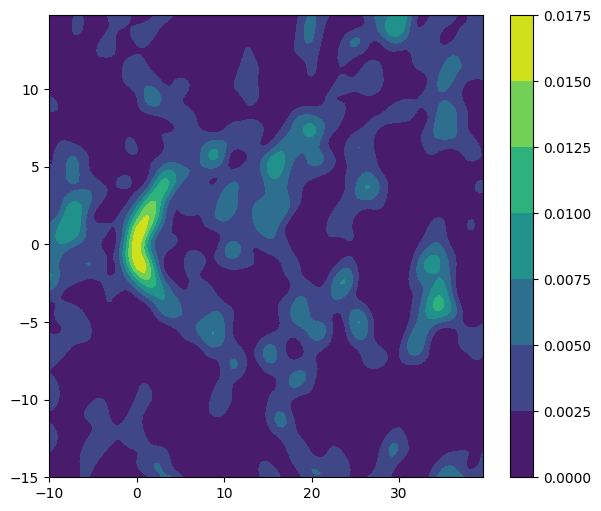

In [ ]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

print("max probability:", predictions_quantum_dmkde_mixed.max())
print("min probability:", predictions_quantum_dmkde_mixed.min())

print("log max probability:", np.log(predictions_quantum_dmkde_mixed.max()))
print("log min probability:", np.log(predictions_quantum_dmkde_mixed.min()))

plt.contourf(x, y, predictions_quantum_dmkde_mixed.reshape([120,120]))
plt.colorbar()
plt.savefig("spiralsdmkde.pdf")

In [ ]:
def evaluate_model(y_true_param, y_pred_param):

  # Kl divergence
  #kl_divergence_temp = tf.keras.metrics.kl_divergence(y_true_param, y_pred_param).numpy()
  kl_divergence_temp = entropy(y_true_param, y_pred_param)

  # Calculate the ranks of the density values
  ranks1 = y_true_param.argsort().argsort()
  ranks2 = y_pred_param.argsort().argsort()

  # Calculate the Spearman correlation
  spearman_corr_temp, _ = spearmanr(ranks1, ranks2)

  # Calculate the absolute differences at each evaluation point
  absolute_differences_temp = np.abs(y_true_param - y_pred_param)

  # Average the absolute differences
  average_error_temp = np.mean(absolute_differences_temp)

  print("KL Divergence:", kl_divergence_temp)
  print("Spearman Correlation:", spearman_corr_temp)
  print("Mean Average Error:", average_error_temp)


In [ ]:
print("                                          ")
print("------ KDE vs DMKDE mixed average --------")
print("                                          ")
evaluate_model(raw_kde_probability, predictions_classical)
print("                                          ")
print("------ KDE vs VQ-KDC QEFF ------------")
print("                                          ")
evaluate_model(raw_kde_probability, predictions_quantum_dmkde_mixed)

                                          
------ KDE vs DMKDE mixed average --------
                                          
KL Divergence: 2.614001995560538
Spearman Correlation: 0.20029738637456945
Mean Average Error: 0.0310361285263212
                                          
------ KDE vs VQ-KDC QEFF ------------
                                          
KL Divergence: 1.8312940828325734
Spearman Correlation: 0.22838820063362367
Mean Average Error: 0.0023208292037253065


# Constants HEA




In [ ]:
GAMMA_DICT = {"Binomial": 2., "Potential 1": 4., "Potential 2": 16., "Arc": 4., "Star": 16.}
GAMMA = GAMMA_DICT["Arc"] ## change GAMMA accordingly
DIM_X = X_train.shape[1]
EPOCHS = 15 ## set 15 for the final experiments
N_RFFS = 32 ## set 64 for the final experiments
RANDOM_STATE = 15
NUM_LAYERS_HEA = 3 ## set 3 for the final experiments
NUM_ANCILLA_QUBITS = 2 ## set 2 for the final experiments
NUM_TOTAL_QUBITS = int(np.ceil(np.log2(N_RFFS)) + NUM_ANCILLA_QUBITS)
HEA_ANSATZ_SIZE = int(NUM_TOTAL_QUBITS*(NUM_LAYERS_HEA+1)*2)

print(NUM_TOTAL_QUBITS, HEA_ANSATZ_SIZE)

7 56


# VQ-KDE Mixed with QRFF with HEA


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
### DMKDE mixed

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr



tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)


class VQKDE_QRFF_HEA:
    r"""
    Defines the ready-to-use Density Matrix Kernel Density Estimation (DMKDE) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """

    def __init__(self, dim_x_param, auto_compile=True, var_hea_ansatz_size_param=64, num_layers_hea_param = 3, gamma=2., epochs=15):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.num_layers_hea = num_layers_hea_param
        self.var_hea_ansatz_size = var_hea_ansatz_size_param
        self.epochs = epochs

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_hea_ansatz_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()


    def layer(
            self,
            U_dagger,
            var_hea_ansatz_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probability of :math:`|000\rangle` state for density estimation.
        """

        n_rffs_temp = U_dagger.shape[1]
        n_total_qubits_temp = int(self.var_hea_ansatz_size/((self.num_layers_hea+1)*2))
        n_qrff_qubits_temp = int(np.log2(n_rffs_temp))

        index_iter_hea  = iter(np.arange(len(var_hea_ansatz_param)))

        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(n_total_qubits_temp)

        def hea_ansatz(qc_param, num_qubits_param, num_layers_param):
        # encoding
          for i in range (0, num_qubits_param):
            qc_param.ry(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
            qc_param.rz(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
        # layers
          for j in range(num_layers_param):
            for i in range (0, num_qubits_param-1):
              qc_param.CNOT(i, i+1)

            for i in range (0, num_qubits_param):
              qc_param.ry(i, theta= var_hea_ansatz_param[next(index_iter_hea)])
              qc_param.rz(i, theta= var_hea_ansatz_param[next(index_iter_hea)])

        ## learning pure state with HEA

        hea_ansatz(self.circuit, n_total_qubits_temp, self.num_layers_hea)

        # Value to predict
        self.circuit.any(
            *[n for n in range(n_qrff_qubits_temp)], unitary=U_dagger
        )

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        return (1./(self.epochs))*\
                tc.backend.real(
                    tf.cast(self.gamma/pi, tf.complex128)*\
                    tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qrff_qubits_temp, n_total_qubits_temp)]
                    )[0, 0]
                )

    def loss(self, x_pred, y_pred):
        return -tf.reduce_sum(tf.math.log(y_pred))

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam(0.0005),
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.loss,
            optimizer=optimizer,
            metrics=[tf.keras.metrics.KLDivergence()],
            **kwargs
        )

    def fit(self, x_train, y_train, batch_size=16, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size=batch_size, epochs=self.epochs, **kwargs)

    def predict(self, x_test):
        r"""
        Method to make predictions with the trained model.

        Args:
            x_test:

        Returns:
            The predictions of the PDF of the input data.
        """

        return (tf.math.pow((self.gamma/(pi)), self.dim_x/2)*\
                self.model.predict(x_test)).numpy()

## VQ-KDE mixed with QRFF with HEA training

In [ ]:
weights_ffs_temp = fm_x.rff_weights.numpy()/2. ## weights extracted from classical DMKDE

weights_ffs_temp.mean(), weights_ffs_temp.std()

(-0.06322023, 0.9963657)

In [ ]:
def predict_features(X_param, var_param, gamma_param):
  X_feat = np.ones((len(X_param), var_param.shape[1]), dtype = np.complex128)
  X_feat[:, :] = np.cos(np.sqrt(gamma_param)*(X_param @ var_param)) - 1j*np.sin(np.sqrt(gamma_param)*(X_param @ var_param))
  X_feat *= np.sqrt(1/(var_param.shape[1]))
  return X_feat

X_feat_train = predict_features(X_train, weights_ffs_temp, GAMMA)
X_feat_test = predict_features(X_plot, weights_ffs_temp, GAMMA)
y_expected =  raw_kde_probability_train

X_feat_train.shape, X_feat_test.shape, y_expected.shape

((28000, 32), (14400, 32), (28000,))

In [ ]:
## Convert states to unitaries

U_train_conjTrans = np.array([np.conjugate(create_U_train(X_feat_train[i]).T) for i in range(len(X_feat_train))])
U_test_conjTrans = np.array([np.conjugate(create_U_train(X_feat_test[i]).T) for i in range(len(X_feat_test))])

U_train_conjTrans.shape, U_test_conjTrans.shape

((28000, 32, 32), (14400, 32, 32))

In [ ]:
vc = VQKDE_QRFF_HEA(dim_x_param = DIM_X, var_hea_ansatz_size_param = HEA_ANSATZ_SIZE, num_layers_hea_param = NUM_LAYERS_HEA, gamma=GAMMA, epochs = EPOCHS)

vc.fit(U_train_conjTrans, y_expected, batch_size=16)

Epoch 1/15
1750/1750 [==============================] - 66s 27ms/step - loss: 92.8377 - kullback_leibler_divergence: 0.1814
Epoch 2/15
1750/1750 [==============================] - 46s 26ms/step - loss: 87.4854 - kullback_leibler_divergence: 0.1190
Epoch 3/15
1750/1750 [==============================] - 47s 27ms/step - loss: 86.4089 - kullback_leibler_divergence: 0.1022
Epoch 4/15
1750/1750 [==============================] - 46s 26ms/step - loss: 86.2694 - kullback_leibler_divergence: 0.0998
Epoch 5/15
1750/1750 [==============================] - 50s 29ms/step - loss: 86.1771 - kullback_leibler_divergence: 0.0982
Epoch 6/15
1750/1750 [==============================] - 49s 28ms/step - loss: 86.0526 - kullback_leibler_divergence: 0.0960
Epoch 7/15
1750/1750 [==============================] - 48s 28ms/step - loss: 85.8476 - kullback_leibler_divergence: 0.0929
Epoch 8/15
1750/1750 [==============================] - 49s 28ms/step - loss: 85.5519 - kullback_leibler_divergence: 0.0892
Epoch 9/

In [ ]:
predictions_quantum_dmkde_mixed = vc.predict(U_test_conjTrans)
predictions_quantum_dmkde_mixed

450/450 [==============================] - 23s 25ms/step


array([0.00602642, 0.00740729, 0.00775068, ..., 0.00630156, 0.00626055,
       0.00689509], dtype=float32)

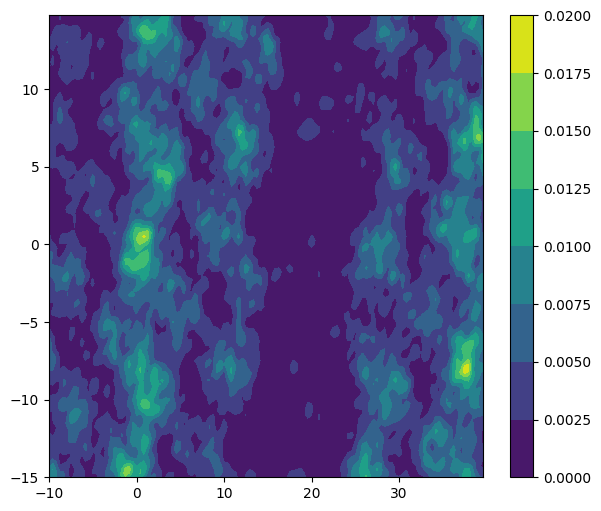

In [ ]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

plt.contourf(x, y, predictions_quantum_dmkde_mixed.reshape([120,120]))
plt.colorbar()
plt.savefig("spiralsdmkde.pdf")

In [ ]:
def evaluate_model(y_true_param, y_pred_param):

  # Kl divergence
  #kl_divergence_temp = tf.keras.metrics.kl_divergence(y_true_param, y_pred_param).numpy()
  kl_divergence_temp = entropy(y_true_param, y_pred_param)

  # Calculate the ranks of the density values
  ranks1 = y_true_param.argsort().argsort()
  ranks2 = y_pred_param.argsort().argsort()

  # Calculate the Spearman correlation
  spearman_corr_temp, _ = spearmanr(ranks1, ranks2)

  # Calculate the absolute differences at each evaluation point
  absolute_differences_temp = np.abs(y_true_param - y_pred_param)

  # Average the absolute differences
  average_error_temp = np.mean(absolute_differences_temp)

  print("KL Divergence:", kl_divergence_temp)
  print("Spearman Correlation:", spearman_corr_temp)
  print("Mean Average Error:", average_error_temp)

In [ ]:
print("                                          ")
print("------ KDE vs DMKDE mixed average --------")
print("                                          ")
evaluate_model(raw_kde_probability, predictions_classical)
print("                                          ")
print("------ KDE vs VQ-KDE QRFF with HEA ------------")
print("                                          ")
evaluate_model(raw_kde_probability, predictions_quantum_dmkde_mixed)
print("                                          ")
print("--DMKDE mixed average vs VQ-KDE QRFF with HEA--")
print("                                          ")
evaluate_model(predictions_classical, predictions_quantum_dmkde_mixed)

                                          
------ KDE vs DMKDE mixed average --------
                                          
KL Divergence: 2.614001995560538
Spearman Correlation: 0.20029738637456945
Mean Average Error: 0.0310361285263212
                                          
------ KDE vs VQ-KDE QRFF with HEA ------------
                                          
KL Divergence: 2.354499290800416
Spearman Correlation: 0.0003574261486822892
Mean Average Error: 0.003494438633035544
                                          
--DMKDE mixed average vs VQ-KDE QRFF with HEA--
                                          
KL Divergence: 0.3119029
Spearman Correlation: 0.441655363433909
Mean Average Error: 0.027668828


# VQ-KDC Mixed with QEFF with HEA

This method uses QEFF, and normalizes the training with the number of epochs.

In [ ]:
### Variational DMKDE with QEFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr

tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)

class VQKDE_QEFF_HEA:
    r"""
    Defines the ready-to-use Density Matrix Kernel Density Estimation (DMKDE) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """

    def __init__(self, num_ffs_param, dim_x_param, auto_compile=True, var_hea_ansatz_size_param=64, num_layers_hea_param = 3, gamma=2., epochs=15):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.n_rffs = num_ffs_param
        self.num_layers_hea = num_layers_hea_param
        self.var_hea_ansatz_size = var_hea_ansatz_size_param
        self.qeff_weights =  tf.random.normal((dim_x_param, int(num_ffs_param*2-2)), mean=0.0, stddev=1.0/np.sqrt(num_ffs_param-1), dtype=tf.dtypes.float64)
        self.epochs = epochs

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_hea_ansatz_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()


    def layer(
            self,
            x_sample_param,
            var_hea_ansatz_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probability of :math:`|000\rangle` state for density estimation.
        """

        n_total_qubits_temp = int(self.var_hea_ansatz_size/((self.num_layers_hea+1)*2))
        n_qeff_qubits_temp = int(np.log2(self.n_rffs))

        ### indices pure state
        index_iter_hea  = iter(np.arange(len(var_hea_ansatz_param)))

        ### indices qeff
        index_iter_qeff = iter(np.arange(self.qeff_weights.shape[1]))

        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(n_total_qubits_temp)

        def hea_ansatz(qc_param, num_qubits_param, num_layers_param):
        # encoding
          for i in range (0, num_qubits_param):
            qc_param.ry(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
            qc_param.rz(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
        # layers
          for j in range(num_layers_param):
            for i in range (0, num_qubits_param-1):
              qc_param.CNOT(i, i+1)

            for i in range (0, num_qubits_param):
              qc_param.ry(i, theta= var_hea_ansatz_param[next(index_iter_hea)])
              qc_param.rz(i, theta= var_hea_ansatz_param[next(index_iter_hea)])

        ## learning pure state with HEA

        hea_ansatz(self.circuit, n_total_qubits_temp, self.num_layers_hea)

        # Value to predict

        x_sample_temp = tf.expand_dims(x_sample_param, axis=0)
        phases_temp = tf.cast(tf.sqrt(self.gamma), tf.float64)*tf.linalg.matmul(tf.cast(x_sample_temp, tf.float64), self.qeff_weights)
        init_qubit_qeff_temp = 0 # qubit at which the qaff mapping starts

        def circuit_base_rz_qeff_n(qc_param, num_qubits_param, target_qubit_param, init_qubit_param):
          if num_qubits_param == 1:
            qc_param.rz(init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
            qc_param.X(init_qubit_param)
            qc_param.rz(init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
          elif num_qubits_param == 2:
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
            qc_param.X(target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
            qc_param.cnot(init_qubit_param, target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
            qc_param.X(target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[0][next(index_iter_qeff)])
            return
          else:
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            qc_param.cnot(num_qubits_param-2+init_qubit_param, target_qubit_param+init_qubit_param)
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            target_qubit_param -= 1

        # Applying the QEFF feature map

        for i in range( n_qeff_qubits_temp - init_qubit_qeff_temp + 1 - 1, 1 - 1, -1):
          circuit_base_rz_qeff_n(self.circuit, i, i - 1, init_qubit_qeff_temp)

        for i in range(init_qubit_qeff_temp, n_qeff_qubits_temp):
          self.circuit.H(i)

        # Trace out ancilla qubits, find probability of [000] state for density estimation

        return (1./(self.epochs))*\
                tc.backend.real(
            tc.quantum.reduced_density_matrix(
                self.circuit.state(),
                cut=[m for m in range(n_qeff_qubits_temp, n_total_qubits_temp)]
            )[0, 0]
        )

    def loss(self, y_train, y_pred):
        return -tf.reduce_sum(tf.math.log(y_pred)) # this loss function works relatively well

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam(0.0005), # originally 0.0005
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.loss,
            optimizer=optimizer,
            metrics=[tf.keras.metrics.KLDivergence()],
            **kwargs
        )

    def fit(self, x_train, y_train, batch_size=16, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size=batch_size, epochs=self.epochs, **kwargs)

    def predict(self, x_test):
        r"""
        Method to make predictions with the trained model.

        Args:
            x_test:

        Returns:
            The predictions of the PDF of the input data.
        """
        return (tf.math.pow((self.gamma/(pi)), self.dim_x/2)*\
            self.model.predict(x_test)).numpy()

## VQ-KDC mixed with QEFF training

In [ ]:
y_train_dmkde_classical =  raw_kde_probability_train

In [ ]:
vc = VQKDE_QEFF_HEA(num_ffs_param=N_RFFS, dim_x_param=DIM_X, var_hea_ansatz_size_param = HEA_ANSATZ_SIZE, num_layers_hea_param = NUM_LAYERS_HEA, gamma=GAMMA, epochs = EPOCHS)

vc.fit(X_train, raw_kde_probability_train, batch_size=16)

Epoch 1/15
7
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
7
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
1000/1750 [================>.............] - ETA: 14s - loss: 97.2610 - kullback_leibler_divergence: 0.2220

KeyboardInterrupt: 

In [ ]:
predictions_quantum_dmkde_mixed = vc.predict(X_plot)
predictions_quantum_dmkde_mixed

450/450 [==============================] - 49s 19ms/step


array([0.00472846, 0.00575312, 0.00630345, ..., 0.00013345, 0.00023025,
       0.00055913], dtype=float32)

max probability: 0.01761637
min probability: 2.3298687e-06
log max probability: -4.0389266
log min probability: -12.969699


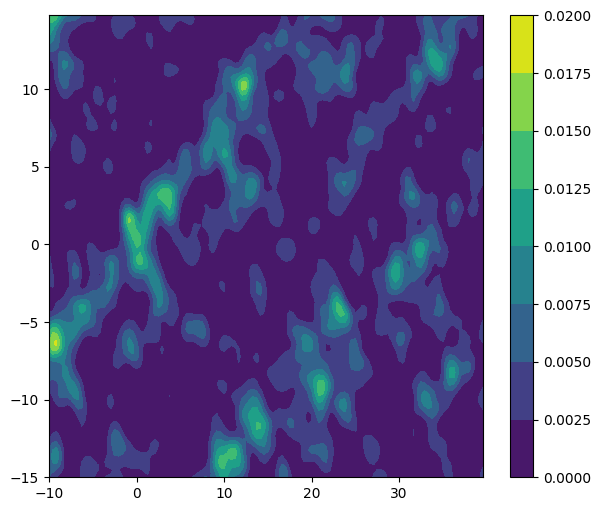

In [ ]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

print("max probability:", predictions_quantum_dmkde_mixed.max())
print("min probability:", predictions_quantum_dmkde_mixed.min())

print("log max probability:", np.log(predictions_quantum_dmkde_mixed.max()))
print("log min probability:", np.log(predictions_quantum_dmkde_mixed.min()))

plt.contourf(x, y, predictions_quantum_dmkde_mixed.reshape([120,120]))
plt.colorbar()
plt.savefig("spiralsdmkde.pdf")

In [ ]:
def evaluate_model(y_true_param, y_pred_param):

  # Kl divergence
  #kl_divergence_temp = tf.keras.metrics.kl_divergence(y_true_param, y_pred_param).numpy()
  kl_divergence_temp = entropy(y_true_param, y_pred_param)

  # Calculate the ranks of the density values
  ranks1 = y_true_param.argsort().argsort()
  ranks2 = y_pred_param.argsort().argsort()

  # Calculate the Spearman correlation
  spearman_corr_temp, _ = spearmanr(ranks1, ranks2)

  # Calculate the absolute differences at each evaluation point
  absolute_differences_temp = np.abs(y_true_param - y_pred_param)

  # Average the absolute differences
  average_error_temp = np.mean(absolute_differences_temp)

  print("KL Divergence:", kl_divergence_temp)
  print("Spearman Correlation:", spearman_corr_temp)
  print("Mean Average Error:", average_error_temp)


In [ ]:
print("                                          ")
print("------ KDE vs DMKDE mixed average --------")
print("                                          ")
evaluate_model(raw_kde_probability, predictions_classical)
print("                                          ")
print("------ KDE vs VQ-KDC QEFF ------------")
print("                                          ")
evaluate_model(raw_kde_probability, predictions_quantum_dmkde_mixed)

                                          
------ KDE vs DMKDE mixed average --------
                                          
KL Divergence: 2.614001995560538
Spearman Correlation: 0.20029738637456945
Mean Average Error: 0.0310361285263212
                                          
------ KDE vs VQ-KDC QEFF ------------
                                          
KL Divergence: 2.1106392888662286
Spearman Correlation: 0.11372831020718387
Mean Average Error: 0.0024355566188194234
